# Seed-seed functional connectivity

## Load libraries

In [1]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiSpheresMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting

## Load datasets

In [2]:
# Load fMRI data
data_path = r"F:\_Sorrow\PhD\FMRI\Datasets\nilearn_data"
dataset = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_path)
func_filename = dataset.func[0]
confounds_filename = dataset.confounds[0]

print(f"func_fliename : {func_filename}")
print(f"confounds_filename : {confounds_filename}")
# Load atlas data
power = datasets.fetch_coords_power_2011()

func_fliename : F:\_Sorrow\PhD\FMRI\Datasets\nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
confounds_filename : F:\_Sorrow\PhD\FMRI\Datasets\nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv


## Extract signals from parcellation

In [3]:
from nilearn import input_data
# Extract coordinates
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Create masker object (spheres with 5 radius) --> NiftiSpheresMasker
# 2) 创建 masker（每个 ROI 是半径 5mm 的小球）
masker = input_data.NiftiSpheresMasker(
    seeds=coords,
    radius=5,
    detrend=True,
    standardize=True,
    memory='nilearn_cache', memory_level=1, verbose=0
)
# Extract timeseries from ROIs using .fit_transform
# 3) 从 ROI 提取时间序列
time_series = masker.fit_transform(func_filename, confounds=confounds_filename)

# Plot shape of timeseries
# 4) 查看提取出来的时间序列矩阵形状
print("timeseries shape:", time_series.shape)

timeseries shape: (168, 264)


## Calculate connectivity

In [4]:
from nilearn.connectome import ConnectivityMeasure
# Create ConnectivityMeasure object (ConnectivityMeasure(kind='correlation'))
# 1) 创建 ConnectivityMeasure 对象，指定相关系数（correlation）
connectivity_measure = ConnectivityMeasure(kind='correlation')

# Calculate correlation using .fit_transform method
# 2) 用 .fit_transform 计算 ROI × ROI 的相关矩阵
#   fit_transform 接受一个列表，每个元素是一名被试的 ROI time series
correlation_matrix = connectivity_measure.fit_transform([time_series])[0]

# 3) 查看矩阵形状
print("correlation matrix shape:", correlation_matrix.shape)

correlation matrix shape: (264, 264)


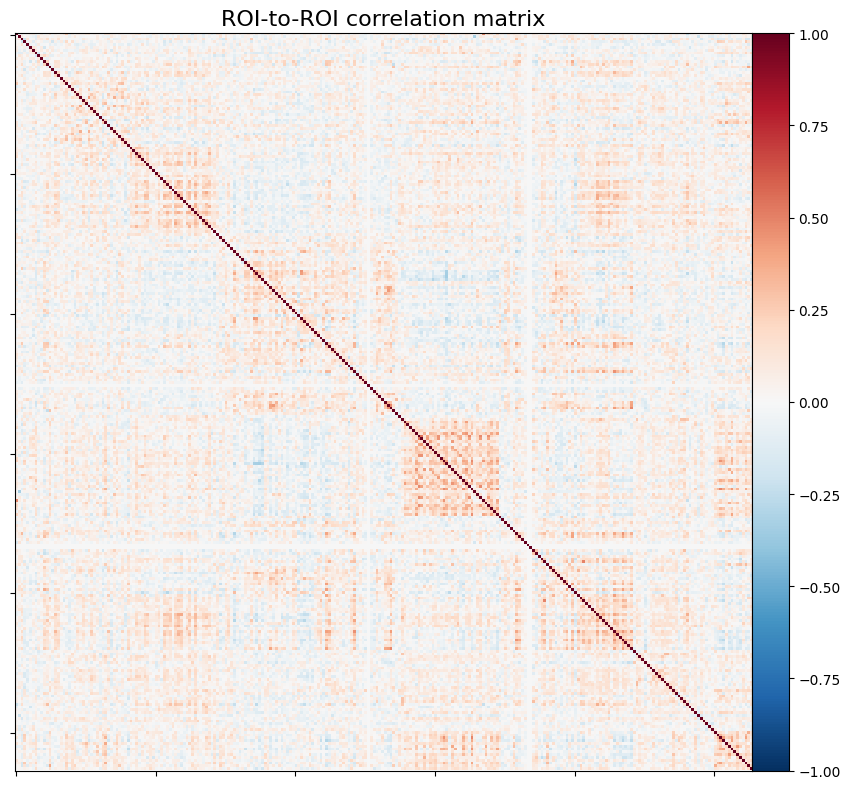

In [5]:
# Plot connectivity matrix (use plot_matrix)
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_matrix
import matplotlib.pyplot as plt

# 1) 创建 ConnectivityMeasure 对象
connectivity_measure = ConnectivityMeasure(kind='correlation')

# 2) 计算 ROI×ROI 相关矩阵
correlation_matrix = connectivity_measure.fit_transform([time_series])[0]

# 3) 画矩阵
plot_matrix(correlation_matrix,
            figure=(10, 8),
            labels=None,          # 这里可以传 ROI 名字
            colorbar=True,
            vmax=1.0, vmin=-1.0,  # 显示-1到1
            title='ROI-to-ROI correlation matrix')

plt.show()


## Plot connectivity matrix

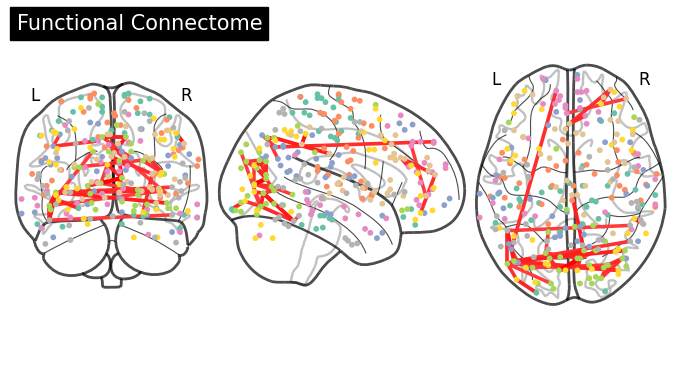

In [6]:
# Using plot_connectome (use plot_connectome)
# 画静态脑网络图
plotting.plot_connectome(
    correlation_matrix,
    coords,
    title="Functional Connectome",
    edge_threshold="99.9%",  # 只画最强的 20% 连线
    node_size=10
)

In [7]:
# Using view_connectome
# 画交互式脑网络（在 notebook 里可拖动、旋转）
view = plotting.view_connectome(
    correlation_matrix,
    coords,
    edge_threshold="99.9%",  # 同样只画强连接
)
view.open_in_browser()  # 打开到浏览器中交互查看

## Redo everything with denoising procedure applied 

In [8]:
from nilearn import datasets, input_data, plotting, connectome
# Extract timeseries & calculate connectivity measures

# 下载数据
dataset = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_path)
func_filename = dataset.func[0]
confounds_filename = dataset.confounds[0]

# 创建 masker 并进行去噪
masker = input_data.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True,
    standardize=True,
    low_pass=0.1,        # 低通滤波
    high_pass=0.01,      # 高通滤波
    t_r=2.5,             # TR，时间分辨率
    memory='nilearn_cache',
    memory_level=1
)

# fit_transform 会自动应用 confounds 去噪
time_series_denoised = masker.fit_transform(func_filename, confounds=confounds_filename)

conn_measure = connectome.ConnectivityMeasure(kind='correlation')
correlation_matrix = conn_measure.fit_transform([time_series_denoised])[0]
print("Correlation matrix shape:", correlation_matrix.shape)  # (ROI数, ROI数)


Correlation matrix shape: (32504, 32504)


In [ ]:
# Plot matrix
# 可视化相关矩阵
plotting.plot_matrix(
    correlation_matrix, figure=(10, 8),
    labels=np.arange(correlation_matrix.shape[0]),
    vmax=1, vmin=-1, title="ROI-ROI Correlation Matrix"
)
plt.show()

In [ ]:
# Using plot_connectome (use plot_connectome)
# 5. 静态脑网络图
plotting.plot_connectome(
    correlation_matrix, coords,
    edge_threshold="95%",  # 只显示最强 5% 的连线
    node_size=10,
    edge_cmap=plt.cm.bwr,  # 蓝色负相关，红色正相关
    title="Functional Connectome"
)

In [ ]:
# Using view_connectome
# 6. 交互式脑网络图
view = plotting.view_connectome(
    correlation_matrix, coords,
    edge_threshold="95%"
)
view.open_in_browser()  # 在浏览器中交互式查看